# Improving the speed of augmented data training using Keras 2

As a complete data science newbie, I decided that it would be helpful to use the latest and greatest Anaconda/Python/Keras/cudnn rather than the official part 1 environment (Python 2.7/Keras 1/cudnn7). 
The switch is fairly straightforward with Keras 2 providing the most headaches (they changed the API without providing a complete backward compatible one). 

In this notebook, I am using Python 3 versions of Jeremy's utils.py and vgg16_bn.py. I'm currently about halfway the course and "ported" the first three lessons - my utils.py might still have incompatibilities I'm not aware of. 

## Rationale for this experiment

I started this course using an old Z800 (24 GB memory, 2x6 2.8 Ghz cores) with a GTX 1080Ti graphics cards. Given that the GPU is one of the fastest ones around, I hoped to get fast training speeds - but alas, performance was disappointing. I switched to a Z640 (32 GB memory, 4 3.6 GHz cores) and I got improved performance - but I still did not understand why as my old Z800 should have done a good enough job. 

As Jeremy encourages experiments, I decided to figure out what the fundamental problem was. This notebook summarizes the problem and solution; I used my Z640, but I don't doubt that I would have been able to get similar performance on the 'old' Z800. 

## Cats vs dogs without data augmentation

Let's start with training cats and dogs using batch normalization; fortunately, Jeremy already provided a nice wrapper for this. 

In [1]:
import sys
sys.path.append('..')      # I am running this in an nbs subdirectory
path = "../data/dogscats/"
from utils3 import *       # utils3 is my python3 version of Jeremy's utils.
import subprocess

Using Theano backend.
/home/karel/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Graphics Device (0000:02:00.0)


In [2]:
# create batches for training
batch_size = 100

# do not use data augmentation.
noAugmGen = image.ImageDataGenerator()
defaultBatches = get_batches(path+'train', shuffle=True, batch_size=batch_size,gen=noAugmGen)
val_batches    = get_batches(path+'valid', shuffle=False,batch_size=batch_size,gen=noAugmGen)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [3]:
# create the vgg
from vgg16bn_3 import *    # my python 3 version of Jeremy's file
vgg = Vgg16()              # vgg with batch normalization and dropout, also loads precomputed coefficients
vgg.ft(2)                  # reconfigure for two classes
vgg.finetune(defaultBatches)      # gets classes from training set

In [4]:
# Start the training of the network. Note the changed API of Keras 2!
batch_size = 64   # your mileage may vary
epoch_steps = ceil(defaultBatches.samples/defaultBatches.batch_size)
val_steps = ceil(val_batches.samples/val_batches.batch_size)

vgg.model.fit_generator(defaultBatches, steps_per_epoch=epoch_steps, epochs=1, 
                        validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
230/230 [==============================] - 111s - loss: 0.1224 - acc: 0.9667 - val_loss: 0.0494 - val_acc: 0.9845


(OPTIONAL: jump to the Conclusions section here)

So, what is the actual usage of the GPU here? I'll run another epoch, but now will capture the GPU load using the nvidia-smi utility. I need to do this as a background process, so I have to manually determine the time required for logging, in this case 120 seconds.

In [5]:
subprocess.Popen("timeout 120 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats.log",shell=True)

vgg.model.fit_generator(defaultBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
230/230 [==============================] - 112s - loss: 0.0880 - acc: 0.9770 - val_loss: 0.0568 - val_acc: 0.9855


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")

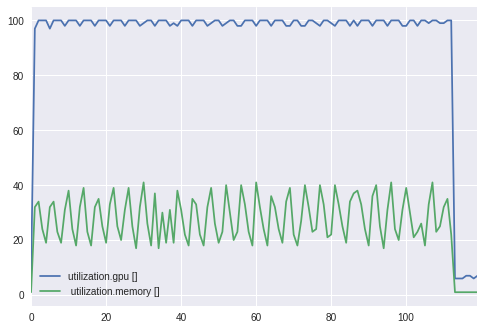

In [7]:
gpu = pd.read_csv("./GPU-stats.log")   # make sure that 120 seconds have expired before running this cell
gpu.plot()
plt.show()

This is what I hoped to see: GPU running at about 100%, suggesting that the GPU is being used very well. The PCI bus is being used at about 30% of its capacity; it is quite "bursty" though. 

## Cats vs dogs with data augmentation

Let's add data augmentation, which is done on the CPU. We have to generate new batches using an image generator that performs the data augmentation, as follows:

In [8]:
# create a generator that performs data augmentation
augmGen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.05,zoom_range=0.05,
     channel_shift_range=10, height_shift_range=0.05, shear_range=0.05, horizontal_flip=True)
# and create new batches using that generator
augBatches = get_batches(path+'train',gen=augmGen,shuffle=True, batch_size=batch_size)
vgg.finetune(augBatches)

Found 23000 images belonging to 2 classes.


Note that the batches don't contain a lot of information; it's actually an iterator that generates a new batch when it is called. I like to think that it is a "recipe" on how to get a batch. 

Let's train with data augmentation:

In [9]:
vgg.model.fit_generator(augBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
230/230 [==============================] - 129s - loss: 0.1480 - acc: 0.9600 - val_loss: 0.0500 - val_acc: 0.9840


Training now takes 20s longer (in previous experiments with low-memory condition, it was actually much slower). I suspect that the GPU is waiting for data, so let's do another epoch with logging (140s) so we can visualize it:

In [16]:
subprocess.Popen("timeout 140 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats.log",shell=True)

vgg.model.fit_generator(augBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps)

Epoch 1/1
230/230 [==============================] - 128s - loss: 0.1008 - acc: 0.9736 - val_loss: 0.0458 - val_acc: 0.9870


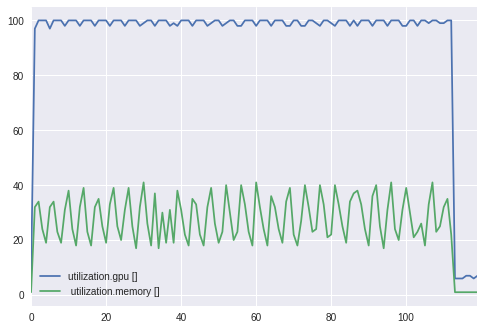

In [11]:
gpu = pd.read_csv("./GPU-stats.log")   # make sure that 140 seconds have expired before running this cell
gpu.plot()
plt.show()

The graph above clearly shows that the GPU doesn't get the data fast enough; with data augmentation, the CPU is now the bottleneck. I'm pretty sure that this was the problem I was running into with my Z800, which has slower CPUs and memory; while the 1080 Ti was very fast, it was not fed data fast enough. 

As default, Keras only uses one thread to do the preprocessing. If we have multiple cores, an obvious solution would be to use more than one thread for data augmentation. How would we do that?

## Faster data augmentation: use multiple threads

There is limited information available on how to implement custom data generators - I suggest you Google it if you're interested. The main issue that folks are running into is that the iterator used by fit_generator (in our case: batches) need to be thread-safe. I believe that some bugs were reported against Keras regarding this.

But: as I'm using the latest Keras (2.0), I suspected that the Keras developers might have made the iterator(s) threadsafe, which turned out to be the case indeed. 

Making the data augmentation faster is absolutely trivial: just specify the number of worker threads and you're done!

In [12]:
subprocess.Popen("timeout 220 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats.log",shell=True)

nrThreads = 3   
vgg.model.fit_generator(augBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps)    # default
vgg.model.fit_generator(augBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps, workers=nrThreads)  # multiple threads

Epoch 1/1
230/230 [==============================] - 132s - loss: 0.1244 - acc: 0.9683 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1/1
230/230 [==============================] - 75s - loss: 0.1112 - acc: 0.9730 - val_loss: 0.0460 - val_acc: 0.9855


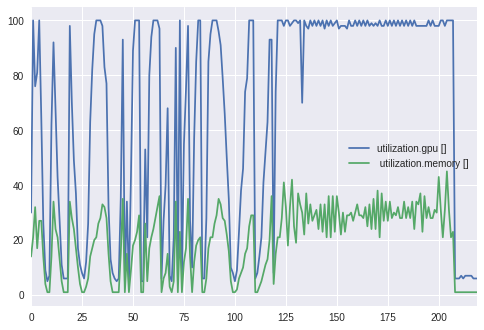

In [13]:
gpu = pd.read_csv("./GPU-stats.log")  
gpu.plot()
plt.show()

I was surprised at the performance improvement (73s for the training step, down from 130s). The 73s is much faster compared to the 110s we obtained for the non-augmented data. I spent quite some time figuring out what is going on and reached the tentative conclusion that specifying multiple worker threads changes the behavior of the iterator. 

If we use the original batches, we obtain the original performance. But if we generate a new batch, we suddenly have much better performance!

In [14]:
# Changing the number of threads changes the behavior of the iterator. Create new batches and do a benchmark.
defaultBatches2 = get_batches(path+'train', shuffle=True, batch_size=batch_size,gen=noAugmGen)
val_batches2    = get_batches(path+'valid', shuffle=False,batch_size=batch_size,gen=noAugmGen)

subprocess.Popen("timeout 200 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats.log",shell=True)

# first epoch without data augmentation, should recreate the original performance
vgg.model.fit_generator(defaultBatches, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches, validation_steps=val_steps)
# second epoch without data augmentation, still single thread, but is faster!
vgg.model.fit_generator(defaultBatches2, steps_per_epoch=epoch_steps, epochs=1, 
                       validation_data=val_batches2, validation_steps=val_steps)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
230/230 [==============================] - 111s - loss: 0.0911 - acc: 0.9782 - val_loss: 0.0429 - val_acc: 0.9835
Epoch 1/1
230/230 [==============================] - 71s - loss: 0.0982 - acc: 0.9777 - val_loss: 0.0475 - val_acc: 0.9836


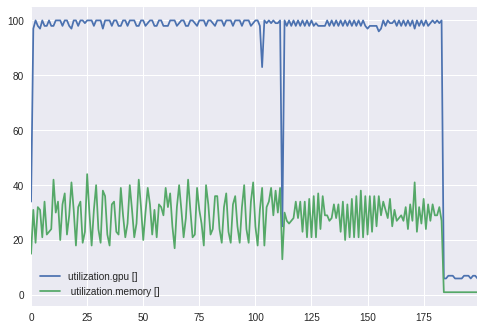

In [15]:
gpu = pd.read_csv("./GPU-stats.log")   
gpu.plot()
plt.show()

## Conclusion

CPU performance can seriously limit the overall throughput during neural training. A solution for this problem is to use multiple threads to feed the GPU; this requires a thread-safe iterator. In Keras 2, the required iterators seem to be threadsafe and adding a simple "workers=N" statement to fit_generator provides a significant speedup. 

Once multi-threading is enabled, the iterators seem to change their behavior to take advantage of multi-threading and even simple "single-thread" performance without data augmentation is significantly faster. 

For those that jumped to the conclusions, here is a demonstration of the performance improvement of single-threaded 

In [6]:
# step 1: non-accelerated training 
vgg.model.fit_generator(defaultBatches, steps_per_epoch=epoch_steps, epochs=1, 
                        validation_data=val_batches, validation_steps=val_steps)
# step 2: throw more threads at it - might not improve performance, but changes the iterator behavior
vgg.model.fit_generator(defaultBatches, steps_per_epoch=epoch_steps, epochs=1, 
                        validation_data=val_batches, validation_steps=val_steps,workers=3)

# step 3: regenerate the batches after activating multi-threading. 
defaultBatches2 = get_batches(path+'train', shuffle=True, batch_size=batch_size,gen=noAugmGen)
val_batches2   = get_batches(path+'valid', shuffle=False,batch_size=batch_size,gen=noAugmGen)
vgg.model.fit_generator(defaultBatches2, steps_per_epoch=epoch_steps, epochs=1, 
                        validation_data=val_batches2, validation_steps=val_steps)

# VOILA, instant performance improvement!!

Epoch 1/1
230/230 [==============================] - 112s - loss: 0.0831 - acc: 0.9797 - val_loss: 0.0695 - val_acc: 0.9835
Epoch 1/1
230/230 [==============================] - 112s - loss: 0.0897 - acc: 0.9763 - val_loss: 0.0550 - val_acc: 0.9835
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
230/230 [==============================] - 72s - loss: 0.0914 - acc: 0.9791 - val_loss: 0.0849 - val_acc: 0.9773
